# Working with xarray

rigid_body_motion provides first class support for xarray data types. xarray has several features that make working with motion data convenient:

1. xarray is designed to combine physical data with metadata such as timestamps.
2. xarray's `Dataset` class can be used as a container for timestamped transformations.
3. Arbitrary metadata can be attached to arrays to keep track of e.g. reference frames.

We recommend you to familiarize yourself with xarray before working through this tutorial. Their [documentation](http://xarray.pydata.org/en/stable/index.html) is an excellent resource for that.

<div class="alert alert-info">
Note
    
The following examples require the `matplotlib`, `xarray` and `netcdf4` libraries.
</div>

In [1]:
import rigid_body_motion as rbm
import xarray as xr
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 5)

## Loading example data

rigid_body_motion includes a recording of head and eye tracking data (using the Intel RealSense T265 as the head tracker and the Pupil Core eye tracker). This data can be loaded with `xr.open_dataset`:

In [2]:
head = xr.open_dataset(rbm.example_data["head"])
head

<xarray.Dataset>
Dimensions:           (time: 66629, cartesian_axis: 3, quaternion_axis: 4)
Coordinates:
  * time              (time) datetime64[ns] 2020-02-02T00:27:14.300365210 ......
  * cartesian_axis    (cartesian_axis) object 'x' 'y' 'z'
  * quaternion_axis   (quaternion_axis) object 'w' 'x' 'y' 'z'
Data variables:
    position          (time, cartesian_axis) float64 ...
    linear_velocity   (time, cartesian_axis) float64 ...
    angular_velocity  (time, cartesian_axis) float64 ...
    confidence        (time) float64 ...
    orientation       (time, quaternion_axis) float64 ...

The dataset includes position and orientation as well as angular and linear velocity of the tracker. Additionally, it includes the physical dimensions `time`, `cartesian_axis` (for position and velocities) and `quaternion_axis` (for orientation). Let's have a look at the position data:

In [3]:
head.position

<xarray.DataArray 'position' (time: 66629, cartesian_axis: 3)>
[199887 values with dtype=float64]
Coordinates:
  * time            (time) datetime64[ns] 2020-02-02T00:27:14.300365210 ... 2...
  * cartesian_axis  (cartesian_axis) object 'x' 'y' 'z'
Attributes:
    long_name:  Position
    units:      m

As you can see, this is a two-dimensional array (called `DataArray` in xarray) with timestamps and explicit names for the physical axes in cartesian coordinates. 

xarray also provides a straightforward way of plotting:

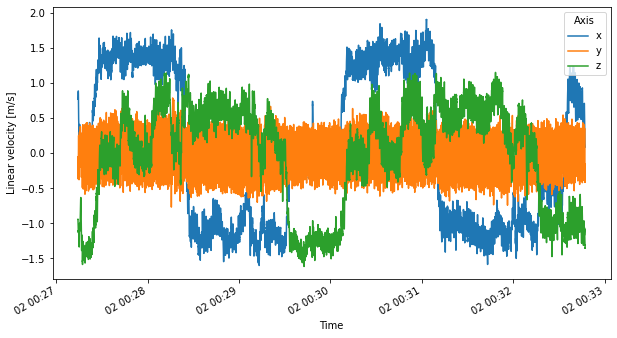

In [4]:
head.linear_velocity.plot.line(x="time")

The example recording is from a test subject wearing the combined head/eye tracker while walking twice around a building. The head tracking data is represented in a world-fixed reference frame whose origin is at the head tracker's location at the start of the recording.

In the next step, we will leverage rigid_body_motion's powerful reference frame mechanism to transform the linear velocity from world to tracker coordinates.

## Reference frame interface

As in the previous tutorial, we begin by registering the world frame as root of the reference frame tree:

In [5]:
rbm.register_frame("world")

Timestamped reference frames can be easily constructed from `Dataset` instances with the [ReferenceFrame.from_dataset()](_generated/rigid_body_motion.ReferenceFrame.from_dataset.rst) method. We need to specify the variables representing translation and rotation of the reference frame as well as the name of the coordinate containing timestamps and the parent frame:

In [6]:
rf_head = rbm.ReferenceFrame.from_dataset(
    head, "position", "orientation", "time", parent="world", name="head"
)

Let's register this reference frame so that we can use it easily for transformations:

In [7]:
rf_head.register()

Now we can use [transform_linear_velocity()](_generated/rigid_body_motion.transform_linear_velocity.rst) to transform the linear velocity to be represented in tracker coordinates:

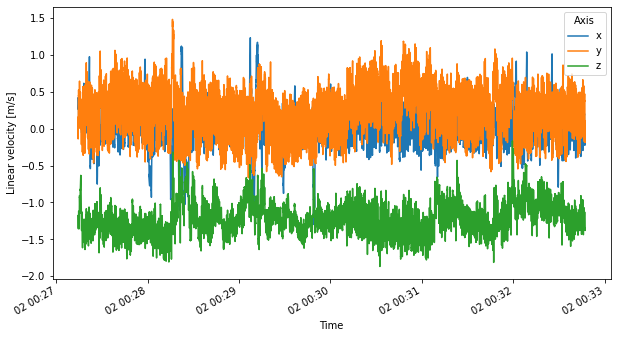

In [8]:
v_head = rbm.transform_linear_velocity(
    head.linear_velocity, outof="world", into="head", what="representation_frame"
)
v_head.plot.line(x="time")

We now see a mean linear velocity of ~1.4 m/s in the negative z direction. This is due to the coordinate system defined by the RealSense T265 where the positive z direction is defined [towards the back of the device](https://github.com/IntelRealSense/librealsense/blob/master/doc/t265.md).